#### Importing Necessary Libraries

In [96]:
! pip install transformers

In [97]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('punkt_tab')
import re
import spacy
import string
from threading import Thread
import psutil
import GPUtil
from GPUtil import getGPUs
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [98]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [99]:
# for tracking training time, memory, CPU and GPU usage

!pip install -q psutil GPUtil

#### Preparing Training, Validation and Testing Data

In [100]:
# importing training data

train = pd.read_csv("train.csv")
train.head()

,review,sentiment
0,SAPS AT SEA <br /><br />Aspect ratio: 1.37:1<b...,negative
1,"If you want mindless action, hot chicks and a ...",positive
2,"""The Woman in Black"" is easily one of the cree...",positive
3,I can barely find the words to describe how mu...,negative
4,What's in here ?! Let me tell you. It's the pr...,negative


In [8]:
train.shape

(30000, 2)

In [9]:
# target label distribution before mapping

train['sentiment'].value_counts()

,count
sentiment,
negative,15065
positive,14935


In [101]:
# encoding sentiments (target label)

train['sentiment'] = train['sentiment'].map({'positive': 1, 'negative': 0})

In [102]:
# target label distribution after mapping

train['sentiment'].value_counts()

,count
sentiment,
0,15065
1,14935


In [103]:
X = train['review']
y = train['sentiment']

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [104]:
print("Training set size:", X_train.shape[0])
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("\n")
print("Evaluation set size:", X_eval.shape[0])
print("Evaluation set class distribution:\n", y_eval.value_counts(normalize=True))

Training set size: 24000
Training set class distribution:
 sentiment
0    0.502167
1    0.497833
Name: proportion, dtype: float64


Evaluation set size: 6000
Evaluation set class distribution:
 sentiment
0    0.502167
1    0.497833
Name: proportion, dtype: float64


In [105]:
# importing test data

test = pd.read_csv("test.csv")
test.head()

,review,sentiment
0,Steven Rea plays a forensic scientist thrust o...,positive
1,As the first of the TV specials offered on the...,positive
2,There may something poetically right in seeing...,negative
3,all i can say about this film is to read the b...,negative
4,I thought it was a pretty good movie and shoul...,positive


In [15]:
test.shape

(20000, 2)

In [106]:
# encoding sentiments (target label)

test['sentiment'] = test['sentiment'].map({'positive': 1, 'negative': 0})

In [107]:
X_test = test['review']
y_test = test['sentiment']

In [108]:
print("Testing set size:", X_test.shape[0])
print("Testing set class distribution:\n", y_test.value_counts(normalize=True))

Testing set size: 20000
Testing set class distribution:
 sentiment
1    0.50325
0    0.49675
Name: proportion, dtype: float64


#### Text Pre-Processing Functions

In [109]:
# downloading required NLTK data
nltk.download('punkt', force = True)
nltk.download('stopwords')
nltk.download('wordnet')

# spacy model for POS tagging
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [110]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk import FreqDist
nltk.download('averaged_perceptron_tagger_eng')

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def extract_elements(dataset):
    stop_words = set(stopwords.words('english'))
    html_tags = set()
    br_tags = set()
    pos_tags = set()
    stopword_tokens = set()

    for review in dataset:
        # Extract HTML tags and <br> tags
        html_tags.update(re.findall(r'<.*?>', review))  # Match all HTML tags
        br_tags.update(re.findall(r'<br.*?>', review))  # Match all <br> variations

        # Tokenize text
        tokens = word_tokenize(review)

        # Debugging: print tokens
        print(f"Tokens for review: {tokens}")

        # Extract stopwords and POS tags
        for word in tokens:
            if word in stop_words:
                stopword_tokens.add(word)  # Add stopwords to the set
        tagged_tokens = pos_tag(tokens)

        # Debugging: print POS tags
        print(f"POS Tags for review: {tagged_tokens}")

        pos_tags.update(tag for word, tag in tagged_tokens)

    # Frequency distribution of stopwords
    stopword_freq = FreqDist(stopword_tokens)

    return stopword_freq, html_tags, br_tags, pos_tags

# Assuming you already have your datasets `train` and `test` loaded
# Extract elements from both train and test datasets
train_stopword_freq, train_html_tags, train_br_tags, train_pos_tags = extract_elements(train)
test_stopword_freq, test_html_tags, test_br_tags, test_pos_tags = extract_elements(test)

# Display Results
print("Stopword Frequency in Train Dataset:")
print(train_stopword_freq)

print("\nStopword Frequency in Test Dataset:")
print(test_stopword_freq)

print("\nHTML Tags in Train Dataset:")
print(train_html_tags)

print("\nHTML Tags in Test Dataset:")
print(test_html_tags)

print("\nBR Tags in Train Dataset:")
print(train_br_tags)

print("\nBR Tags in Test Dataset:")
print(test_br_tags)

print("\nPOS Tags in Train Dataset:")
print(train_pos_tags)

print("\nPOS Tags in Test Dataset:")
print(test_pos_tags)

Tokens for review: ['review']
POS Tags for review: [('review', 'NN')]
Tokens for review: ['sentiment']
POS Tags for review: [('sentiment', 'NN')]
Tokens for review: ['review']
POS Tags for review: [('review', 'NN')]
Tokens for review: ['sentiment']
POS Tags for review: [('sentiment', 'NN')]
Stopword Frequency in Train Dataset:
<FreqDist with 0 samples and 0 outcomes>

Stopword Frequency in Test Dataset:
<FreqDist with 0 samples and 0 outcomes>

HTML Tags in Train Dataset:
set()

HTML Tags in Test Dataset:
set()

BR Tags in Train Dataset:
set()

BR Tags in Test Dataset:
set()

POS Tags in Train Dataset:
{'NN'}

POS Tags in Test Dataset:
{'NN'}


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [111]:
# functions

# 1. Tokenization
def tokenize_text(text):
    return word_tokenize(text)

# 2. Stopword Removal
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# 3. Stemming
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

# 4. Lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# 5. Part-of-Speech Tagging (POS Tagging)
def pos_tag_tokens(text):
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]

# 6. HTML Tag Removal
def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

In [112]:
def preprocess_text(text, use_stemming=False):
    # Step 1: Remove HTML tags (including <br> tags) and standalone 'br' tokens
    text = re.sub(r'<.*?>', '', text)  # Removes all HTML tags
    text = re.sub(r'\bbr\b', ' ', text)  # Removes standalone 'br' tokens
    text = re.sub(r'<br\s*/?>', ' ', text)  # Replace <br> tags with a space
    text = re.sub(r'<br\s*.*?>', ' ', text)  # Remove <br> tags with additional attributes
    text = re.sub(r'\s+', ' ', text).strip()  # Removes extra whitespace

    # Step 2: Convert to lowercase
    text = text.lower()

    # Step 3: Tokenize the text (using word_tokenize from nltk)
    tokens = word_tokenize(text)

    # Step 4: Remove punctuation using string translation
    tokens = [word.translate(str.maketrans('', '', string.punctuation)) for word in tokens]

    # Step 5: Remove stopwords (using NLTK's stopwords list)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word != '']

    # Step 6: Apply stemming or lemmatization
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Step 7: Return the cleaned text as a single string
    return ' '.join(tokens)

In [113]:
# function for TF-IDF vectorization

def create_tfidf_vectors(corpus, max_features=1000, ngram_range=(1, 1)):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names

In [114]:
X_train.head()

,review
4187,I saw The Greek Tycoon when it first came out ...
7380,"I throughly enjoyed this short, even as a Toro..."
16768,"Despite its pedigree, the most interesting thi..."
689,"Like a lot of series pilots, Dark Angel's open..."
7711,I watched this film on the advice of a friend ...


In [115]:
X_eval.head()

,review
3604,This movie twists the facts of Anne and Mary's...
19751,Pierce Brosnan will probably be the only thing...
26037,It is OK movie if it would be done by high sch...
17472,"""A Damsel in Distress"" is definitely not one o..."
10196,For those of you out there who have seen this ...


In [116]:
X_test.head()

,review
0,Steven Rea plays a forensic scientist thrust o...
1,As the first of the TV specials offered on the...
2,There may something poetically right in seeing...
3,all i can say about this film is to read the b...
4,I thought it was a pretty good movie and shoul...


#### Pre-Processing All Data

In [117]:
# applying preprocessing to all data

from nltk.tokenize import word_tokenize

train_processed = X_train.apply(lambda x: preprocess_text(x, use_stemming=False))
val_processed = X_eval.apply(lambda x: preprocess_text(x, use_stemming=False))
test_processed = X_test.apply(lambda x: preprocess_text(x, use_stemming=False))

In [118]:
# Check if any of the processed data contains <br> tags
contains_br_train_processed = train_processed.str.contains(r'<br\s*/?>', regex=True)
contains_br_val_processed = val_processed.str.contains(r'<br\s*/?>', regex=True)
contains_br_test_processed = test_processed.str.contains(r'<br\s*/?>', regex=True)

# Print the number of processed reviews containing <br> tags
print("Processed Train data with <br> tags:", contains_br_train_processed.sum())
print("Processed Validation data with <br> tags:", contains_br_val_processed.sum())
print("Processed Test data with <br> tags:", contains_br_test_processed.sum())

Processed Train data with <br> tags: 0
Processed Validation data with <br> tags: 0
Processed Test data with <br> tags: 0


In [29]:
train_processed.head()

,review
4187,saw greek tycoon first came 1978 found extreme...
7380,throughly enjoyed short even toronto maple lea...
16768,despite pedigree interesting thing series anim...
689,like lot series pilot dark angel opener show m...
7711,watched film advice friend assured one funnies...


In [30]:
val_processed.head()

,review
3604,movie twist fact anne mary life something unre...
19751,pierce brosnan probably thing familiar richard...
26037,ok movie would done high school kid friend way...
17472,damsel distress definitely one fred astaire be...
10196,seen pic vhs would recommend dvd fact vhs utte...


In [31]:
test_processed.head()

,review
0,steven rea play forensic scientist thrust job ...
1,first tv special offered elaborate box set bar...
2,may something poetically right seeing dentist ...
3,say film read back video case put back shelf p...
4,thought pretty good movie released theater fir...


### Visualizations

In [123]:
import os

# Specify the directory path
directory = '/content/'

if not os.path.exists(directory):
    os.makedirs(directory)

### Train Data

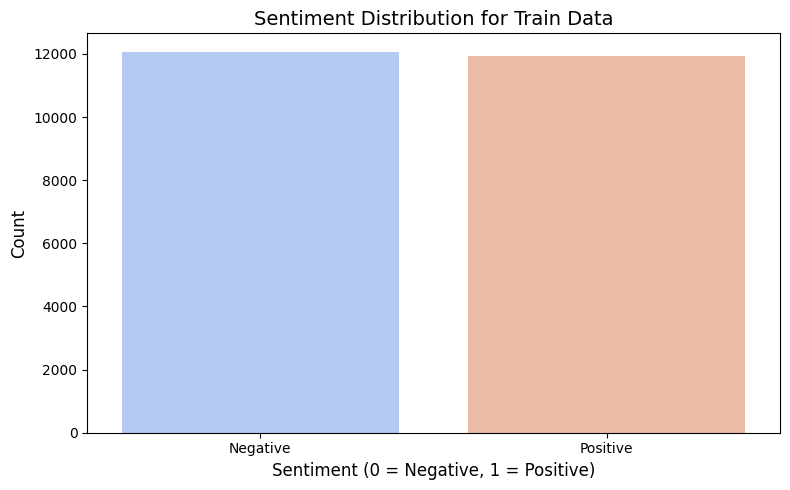

In [124]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, palette='coolwarm')
plt.title('Sentiment Distribution for Train Data', fontsize=14)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], labels=['Negative', 'Positive'])
plt.tight_layout()
file_path = '/content/sentiment_distribution_train.png'
plt.savefig(file_path)
plt.show()

In [125]:
from google.colab import files

files.download('/content/sentiment_distribution_train.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

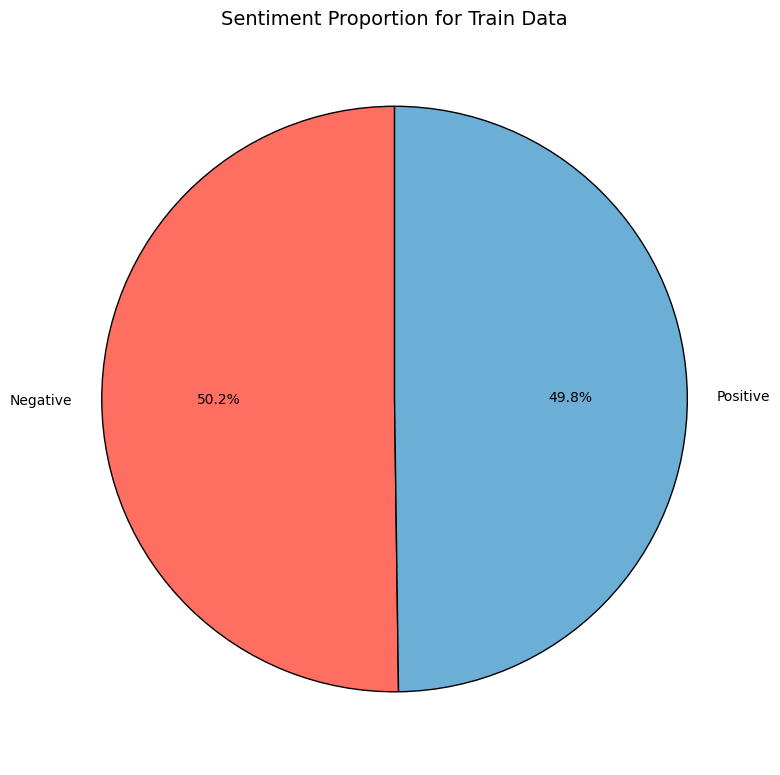

In [127]:
plt.figure(figsize=(8, 8))
plt.pie(
    y_train.value_counts(),
    labels=['Negative', 'Positive'],
    autopct='%1.1f%%',
    colors=['#FF6F61', '#6BAED6'],
    startangle=90,  # Rotate to start from the top
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'}  # Enhance aesthetics
)
plt.title('Sentiment Proportion for Train Data', fontsize=14)
plt.tight_layout()
file_path = '/content/sentiment_proportion_train_pie.png'
plt.savefig(file_path)
plt.show()

In [128]:
files.download('/content/sentiment_proportion_train_pie.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

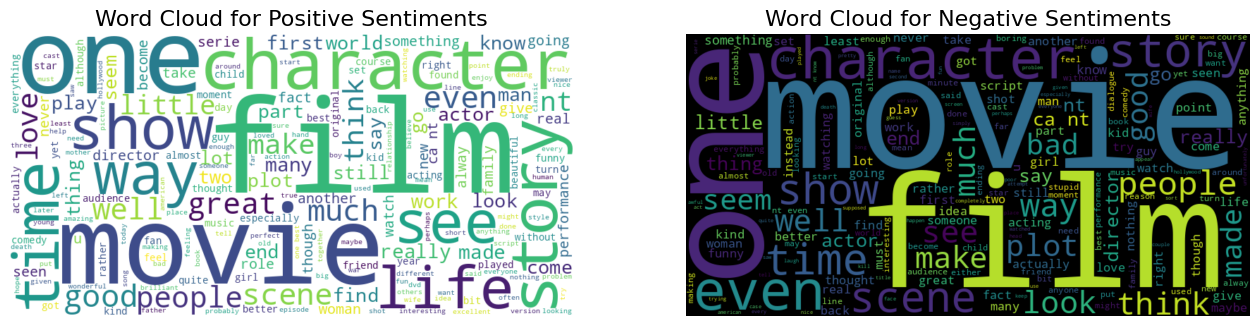

In [129]:
# Filter text based on sentiment
positive_text = " ".join(train_processed[y_train == 1])
negative_text = " ".join(train_processed[y_train == 0])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color="black").generate(negative_text)


plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Positive Sentiments", fontsize=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Negative Sentiments", fontsize=16)
plt.axis("off")
file_path = '/content/sentiment_word_cloud_train.png'
plt.savefig(file_path)
plt.show()

In [130]:
files.download('/content/sentiment_word_cloud_train.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

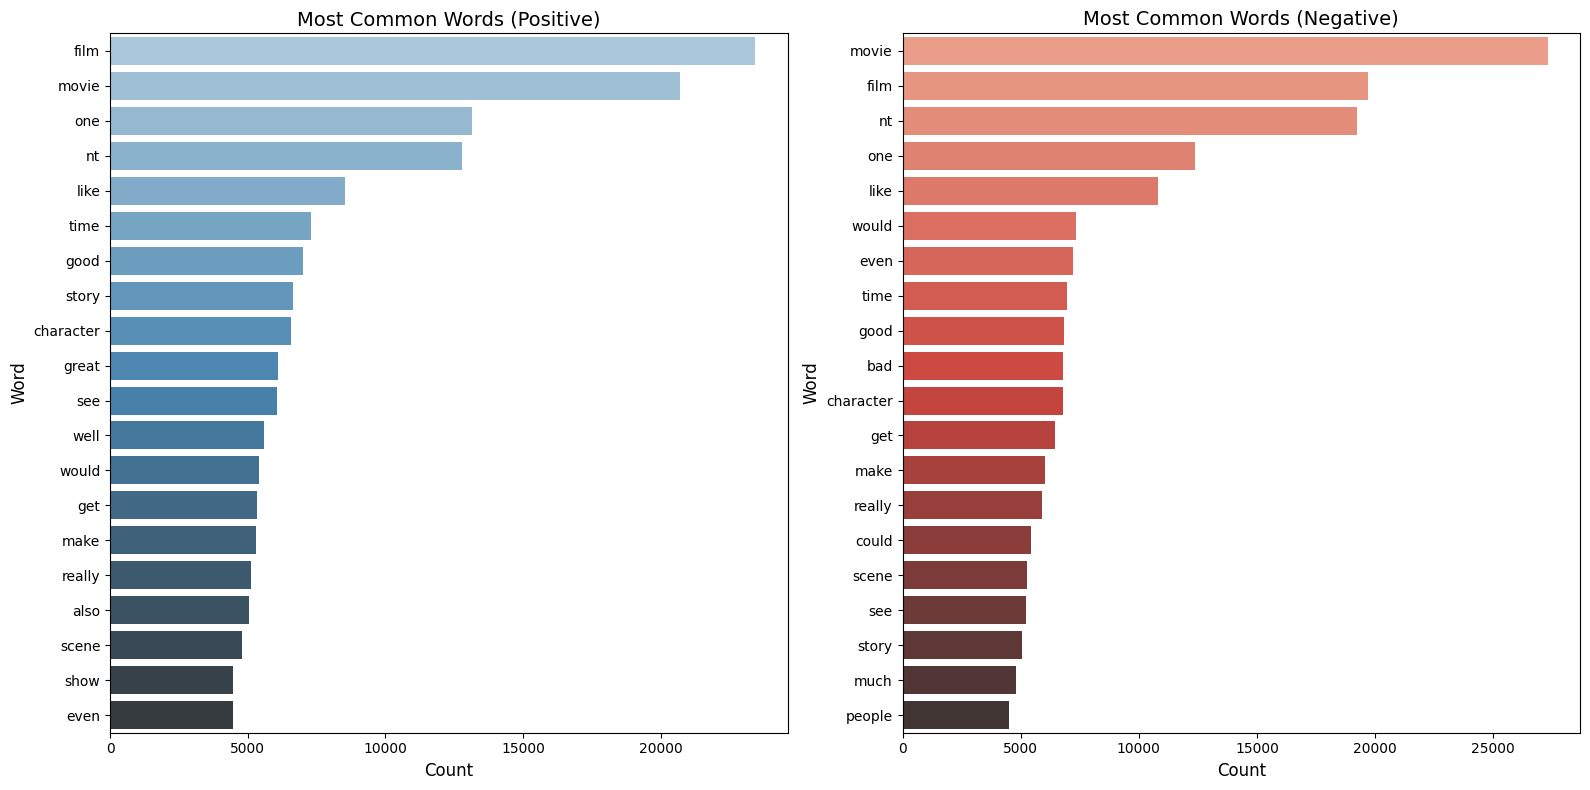

In [131]:
from collections import Counter

# Filter text based on sentiment
positive_text = " ".join(train_processed[y_train == 1])
negative_text = " ".join(train_processed[y_train == 0])

# Function to get most common words
def get_most_common_words(text, n=20):
    words = text.split()  # Split into complete words
    return Counter(words).most_common(n)

# Get most common words
positive_words = get_most_common_words(positive_text)
negative_words = get_most_common_words(negative_text)

# Convert to DataFrame for visualization
pos_df = pd.DataFrame(positive_words, columns=['Word', 'Count'])
neg_df = pd.DataFrame(negative_words, columns=['Word', 'Count'])

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(data=pos_df, x='Count', y='Word', ax=axs[0], palette='Blues_d')
axs[0].set_title('Most Common Words (Positive)', fontsize=14)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Word', fontsize=12)

sns.barplot(data=neg_df, x='Count', y='Word', ax=axs[1], palette='Reds_d')
axs[1].set_title('Most Common Words (Negative)', fontsize=14)
axs[1].set_xlabel('Count', fontsize=12)
axs[1].set_ylabel('Word', fontsize=12)
plt.tight_layout()
file_path = '/content/sentiment_common_words_train.png'
plt.savefig(file_path)
plt.show()

In [132]:
files.download('/content/sentiment_common_words_train.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

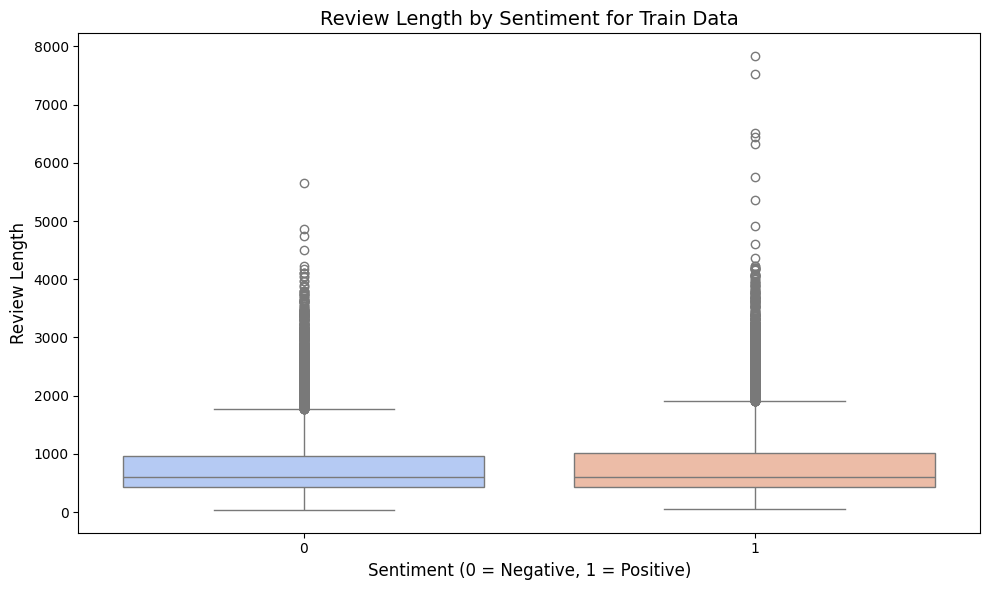

In [133]:
# Calculate review lengths
review_lengths = [len(review) for review in train_processed]

# Create the plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_train, y=review_lengths, palette='coolwarm')
plt.title('Review Length by Sentiment for Train Data', fontsize=14)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Review Length', fontsize=12)
plt.tight_layout()
file_path = '/content/sentiment_word_length_train.png'
plt.savefig(file_path)
plt.show()

In [134]:
files.download('/content/sentiment_word_length_train.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test Data

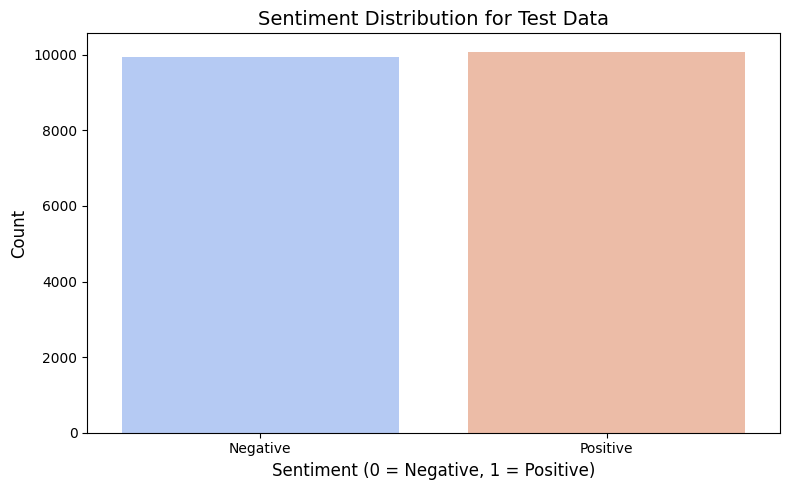

In [135]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_test, palette='coolwarm')
plt.title('Sentiment Distribution for Test Data', fontsize=14)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], labels=['Negative', 'Positive'])
plt.tight_layout()
file_path = '/content/sentiment_distribution_test.png'
plt.savefig(file_path)
plt.show()

In [136]:
files.download('/content/sentiment_distribution_test.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

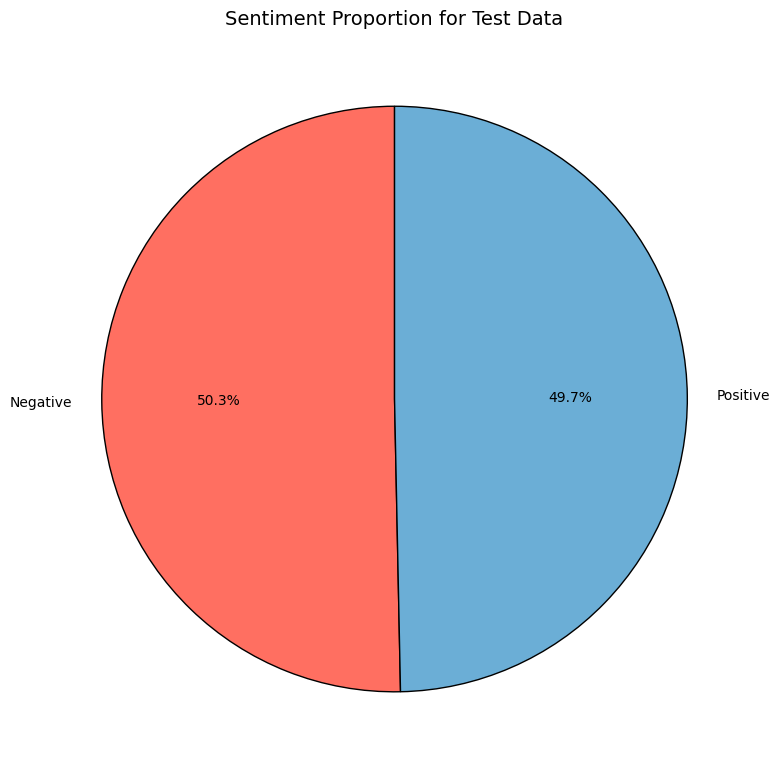

In [137]:
plt.figure(figsize=(8, 8))
plt.pie(
    y_test.value_counts(),
    labels=['Negative', 'Positive'],
    autopct='%1.1f%%',
    colors=['#FF6F61', '#6BAED6'],
    startangle=90,  # Rotate to start from the top
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'}  # Enhance aesthetics
)
plt.title('Sentiment Proportion for Test Data', fontsize=14)
plt.tight_layout()
file_path = '/content/sentiment_proportion_test_pie.png'
plt.savefig(file_path)
plt.show()

In [138]:
files.download('/content/sentiment_proportion_test_pie.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

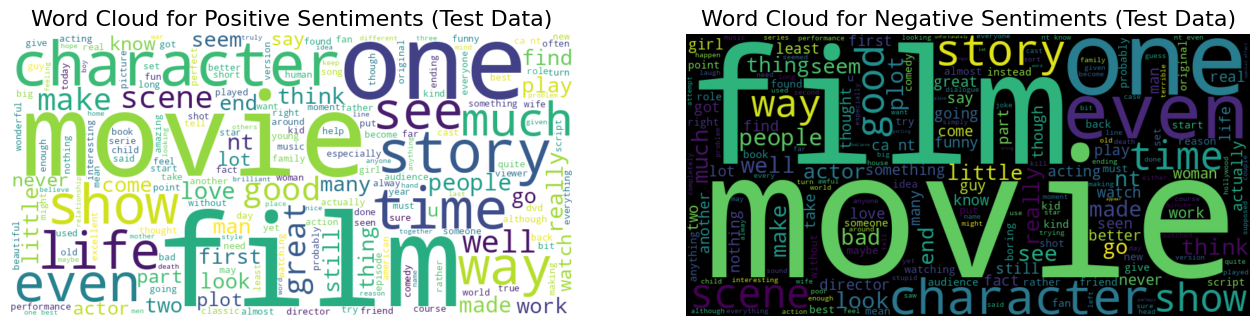

In [139]:
# Filter text based on sentiment for the test set
positive_text = " ".join(test_processed[y_test == 1])
negative_text = " ".join(test_processed[y_test == 0])

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color="black").generate(negative_text)


plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Positive Sentiments (Test Data)", fontsize=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Negative Sentiments (Test Data)", fontsize=16)
plt.axis("off")
file_path = '/content/sentiment_word_cloud_test.png'
plt.savefig(file_path)
plt.show()

In [140]:
files.download('/content/sentiment_word_cloud_test.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

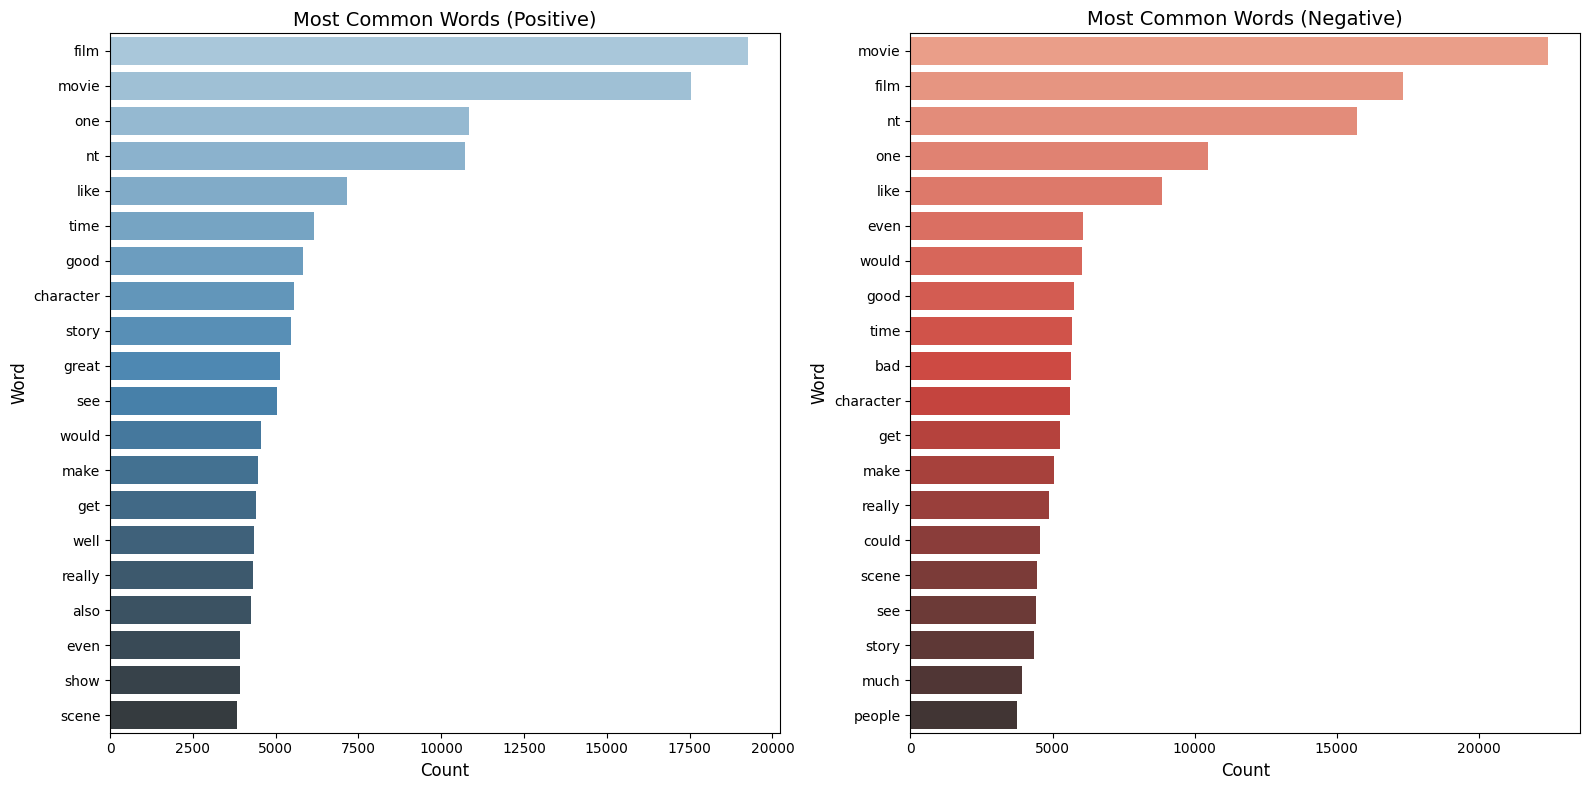

In [141]:
# Filter text based on sentiment
positive_text = " ".join(test_processed[y_test == 1])
negative_text = " ".join(test_processed[y_test == 0])

# Function to get most common words
def get_most_common_words(text, n=20):
    words = text.split()  # Split into complete words
    return Counter(words).most_common(n)

# Get most common words
positive_words = get_most_common_words(positive_text)
negative_words = get_most_common_words(negative_text)

# Convert to DataFrame for visualization
pos_df = pd.DataFrame(positive_words, columns=['Word', 'Count'])
neg_df = pd.DataFrame(negative_words, columns=['Word', 'Count'])

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(data=pos_df, x='Count', y='Word', ax=axs[0], palette='Blues_d')
axs[0].set_title('Most Common Words (Positive)', fontsize=14)
axs[0].set_xlabel('Count', fontsize=12)
axs[0].set_ylabel('Word', fontsize=12)

sns.barplot(data=neg_df, x='Count', y='Word', ax=axs[1], palette='Reds_d')
axs[1].set_title('Most Common Words (Negative)', fontsize=14)
axs[1].set_xlabel('Count', fontsize=12)
axs[1].set_ylabel('Word', fontsize=12)

plt.tight_layout()
file_path = '/content/sentiment_common_words_test.png'
plt.savefig(file_path)
plt.show()

In [142]:
files.download('/content/sentiment_common_words_test.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

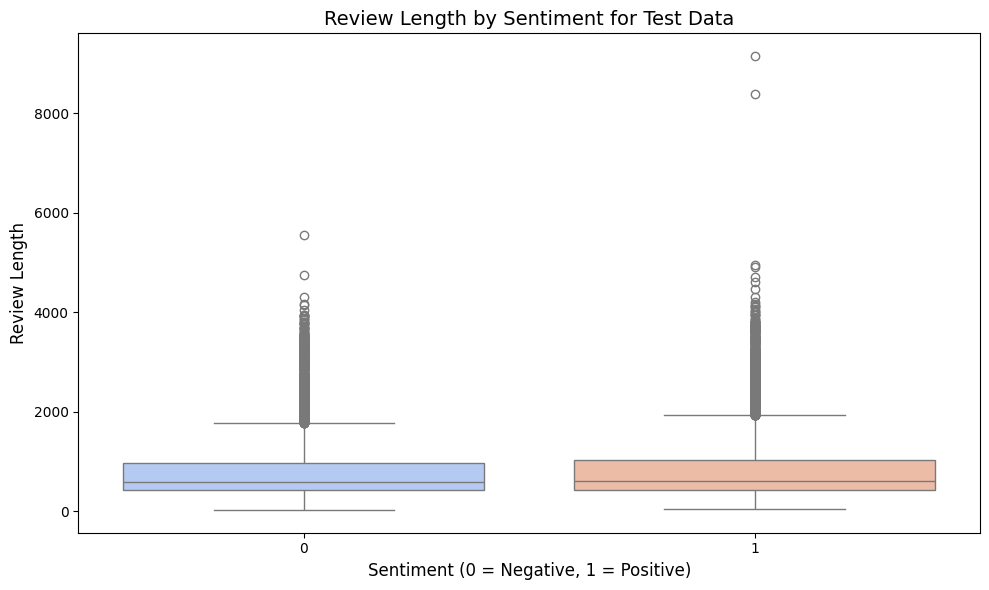

In [143]:
# Calculate review lengths
review_lengths = [len(review) for review in test_processed]

# Create the plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_test, y=review_lengths, palette='coolwarm')
plt.title('Review Length by Sentiment for Test Data', fontsize=14)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)', fontsize=12)
plt.ylabel('Review Length', fontsize=12)
plt.tight_layout()
file_path = '/content/sentiment_word_length_test.png'
plt.savefig(file_path)
plt.show()

In [144]:
files.download('/content/sentiment_word_length_test.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Creating TF-IDF Matrices

In [50]:
train_tfidf, train_feature_names = create_tfidf_vectors(train_processed, max_features=1000, ngram_range=(1, 2))
val_tfidf, _ = create_tfidf_vectors(val_processed, max_features=1000, ngram_range=(1, 2))
test_tfidf, _ = create_tfidf_vectors(test_processed, max_features=1000, ngram_range=(1, 2))

In [51]:
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(), columns=train_feature_names)
val_tfidf_df = pd.DataFrame(val_tfidf.toarray(), columns=train_feature_names)  # using training feature names
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=train_feature_names)  # using training feature names

In [52]:
train_tfidf_df.head()

,10,20,30,70,80,90,ability,able,absolutely,accent,across,act,acted,acting,action,actor,actress,actual,actually,adaptation,add,admit,adult,adventure,age,ago,agree,air,alien,almost,alone,along,already,also,although,always,amazing,america,american,among,amount,animal,animation,annoying,another,answer,anyone,anything,anyway,apart,apparently,appear,appearance,appears,around,art,ask,aspect,atmosphere,attack,attempt,attention,audience,average,avoid,award,away,awful,baby,back,background,bad,bad guy,bad movie,badly,band,based,basic,basically,battle,beautiful,beauty,became,become,becomes,begin,beginning,behind,believable,believe,best,better,beyond,big,biggest,bill,bit,bizarre,black,blood,blue,body,book,bored,boring,box,boy,brain,break,brilliant,bring,brings,british,brother,brought,budget,bunch,business,buy,ca,ca nt,call,called,came,camera,car,care,career,cartoon,case,cast,casting,cat,caught,cause,century,certain,certainly,chance,change,channel,character,chase,cheap,check,cheesy,child,choice,cinema,cinematography,city,class,classic,clear,clearly,clever,close,cold,college,color,come,comedy,comic,coming,comment,common,company,compared,complete,completely,concept,considering,control,convincing,cool,cop,copy,costume,could,could nt,country,couple,course,cover,crap,crazy,create,created,creature,credit,creepy,crew,crime,cry,culture,cut,cute,dance,dark,daughter,david,day,de,dead,deal,death,decent,decided,decides,deep,definitely,depth,deserves,despite,detail,development,dialog,dialogue,die,died,different,difficult,directed,directing,direction,director,disappointed,disney,doctor,documentary,dog,done,door,doubt,dr,drama,dramatic,dream,drive,drug,due,dull,dumb,dvd,earlier,early,earth,easily,easy,editing,effect,effort,either,element,else,emotion,emotional,end,ended,ending,english,enjoy,enjoyable,enjoyed,enough,entertaining,entertainment,entire,entirely,episode,era,escape,especially,etc,even,even though,event,eventually,ever,ever seen,every,everyone,everything,evil,exactly,example,excellent,except,expect,expected,expecting,experience,extremely,eye,face,fact,fails,fairly,fall,familiar,family,famous,fan,fantastic,fantasy,far,fast,father,favorite,fear,feature,feel,feel like,feeling,felt,female,fight,fighting,figure,film,film ever,film like,film nt,film one,filmed,filmmaker,final,finally,find,fine,fire,first,first time,fit,five,flat,flick,focus,follow,following,footage,force,forced,forget,form,forward,found,four,free,french,friend,front,full,fun,funny,future,game,gave,gay,general,genre,george,german,get,getting,ghost,girl,girlfriend,give,given,giving,go,god,going,gone,good,good movie,gore,got,great,greatest,group,guess,gun,guy,hair,half,hand,happen,happened,happens,happy,hard,hardly,hate,head,hear,heard,heart,hell,help,hero,high,high school,highly,hilarious,history,hit,hold,hole,hollywood,home,hope,horrible,horror,horror film,horror movie,hot,hour,house,however,huge,human,humor,hurt,husband,idea,image,imagine,imdb,important,including,incredible,incredibly,indeed,indian,inside,instead,interest,interested,interesting,involved,island,issue,italian,jack,james,jane,japanese,job,joe,john,joke,keep,kept,kid,kill,killed,killer,killing,kind,king,knew,know,known,la,lack,lady,lame,land,language,large,last,late,later,laugh,laughing,lead,leading,leaf,learn,least,leave,lee,left,less,let,level,life,light,like,liked,line,list,little,live,living,local,location,long,look,look like,looked,looking,lost,lot,love,loved,lover,low,low budget,mad,made,main,main character,major,make,make movie,make sense,making,male,man,manages,many,mark,married,master,masterpiece,match,material,matter,may,maybe,mean,meaning,meant,meet,member,memorable,memory,men,mention,mentioned,mess,message,michael,middle,might,mind,minute,miss,missed,missing,mistake,modern,moment,money,monster,mostly,mother,move,movie,movie ever,movie like,movie made,movie nt,movie one,movie would,moving,mr,much,much better,murder,music,musical,must,mystery,name,named,nature,near,nearly,need,needed,neither,never,new,new york,n

In [53]:
val_tfidf_df.head()

,10,20,30,70,80,90,ability,able,absolutely,accent,across,act,acted,acting,action,actor,actress,actual,actually,adaptation,add,admit,adult,adventure,age,ago,agree,air,alien,almost,alone,along,already,also,although,always,amazing,america,american,among,amount,animal,animation,annoying,another,answer,anyone,anything,anyway,apart,apparently,appear,appearance,appears,around,art,ask,aspect,atmosphere,attack,attempt,attention,audience,average,avoid,award,away,awful,baby,back,background,bad,bad guy,bad movie,badly,band,based,basic,basically,battle,beautiful,beauty,became,become,becomes,begin,beginning,behind,believable,believe,best,better,beyond,big,biggest,bill,bit,bizarre,black,blood,blue,body,book,bored,boring,box,boy,brain,break,brilliant,bring,brings,british,brother,brought,budget,bunch,business,buy,ca,ca nt,call,called,came,camera,car,care,career,cartoon,case,cast,casting,cat,caught,cause,century,certain,certainly,chance,change,channel,character,chase,cheap,check,cheesy,child,choice,cinema,cinematography,city,class,classic,clear,clearly,clever,close,cold,college,color,come,comedy,comic,coming,comment,common,company,compared,complete,completely,concept,considering,control,convincing,cool,cop,copy,costume,could,could nt,country,couple,course,cover,crap,crazy,create,created,creature,credit,creepy,crew,crime,cry,culture,cut,cute,dance,dark,daughter,david,day,de,dead,deal,death,decent,decided,decides,deep,definitely,depth,deserves,despite,detail,development,dialog,dialogue,die,died,different,difficult,directed,directing,direction,director,disappointed,disney,doctor,documentary,dog,done,door,doubt,dr,drama,dramatic,dream,drive,drug,due,dull,dumb,dvd,earlier,early,earth,easily,easy,editing,effect,effort,either,element,else,emotion,emotional,end,ended,ending,english,enjoy,enjoyable,enjoyed,enough,entertaining,entertainment,entire,entirely,episode,era,escape,especially,etc,even,even though,event,eventually,ever,ever seen,every,everyone,everything,evil,exactly,example,excellent,except,expect,expected,expecting,experience,extremely,eye,face,fact,fails,fairly,fall,familiar,family,famous,fan,fantastic,fantasy,far,fast,father,favorite,fear,feature,feel,feel like,feeling,felt,female,fight,fighting,figure,film,film ever,film like,film nt,film one,filmed,filmmaker,final,finally,find,fine,fire,first,first time,fit,five,flat,flick,focus,follow,following,footage,force,forced,forget,form,forward,found,four,free,french,friend,front,full,fun,funny,future,game,gave,gay,general,genre,george,german,get,getting,ghost,girl,girlfriend,give,given,giving,go,god,going,gone,good,good movie,gore,got,great,greatest,group,guess,gun,guy,hair,half,hand,happen,happened,happens,happy,hard,hardly,hate,head,hear,heard,heart,hell,help,hero,high,high school,highly,hilarious,history,hit,hold,hole,hollywood,home,hope,horrible,horror,horror film,horror movie,hot,hour,house,however,huge,human,humor,hurt,husband,idea,image,imagine,imdb,important,including,incredible,incredibly,indeed,indian,inside,instead,interest,interested,interesting,involved,island,issue,italian,jack,james,jane,japanese,job,joe,john,joke,keep,kept,kid,kill,killed,killer,killing,kind,king,knew,know,known,la,lack,lady,lame,land,language,large,last,late,later,laugh,laughing,lead,leading,leaf,learn,least,leave,lee,left,less,let,level,life,light,like,liked,line,list,little,live,living,local,location,long,look,look like,looked,looking,lost,lot,love,loved,lover,low,low budget,mad,made,main,main character,major,make,make movie,make sense,making,male,man,manages,many,mark,married,master,masterpiece,match,material,matter,may,maybe,mean,meaning,meant,meet,member,memorable,memory,men,mention,mentioned,mess,message,michael,middle,might,mind,minute,miss,missed,missing,mistake,modern,moment,money,monster,mostly,mother,move,movie,movie ever,movie like,movie made,movie nt,movie one,movie would,moving,mr,much,much better,murder,music,musical,must,mystery,name,named,nature,near,nearly,need,needed,neither,never,new,new york,n

In [54]:
test_tfidf_df.head()

,10,20,30,70,80,90,ability,able,absolutely,accent,across,act,acted,acting,action,actor,actress,actual,actually,adaptation,add,admit,adult,adventure,age,ago,agree,air,alien,almost,alone,along,already,also,although,always,amazing,america,american,among,amount,animal,animation,annoying,another,answer,anyone,anything,anyway,apart,apparently,appear,appearance,appears,around,art,ask,aspect,atmosphere,attack,attempt,attention,audience,average,avoid,award,away,awful,baby,back,background,bad,bad guy,bad movie,badly,band,based,basic,basically,battle,beautiful,beauty,became,become,becomes,begin,beginning,behind,believable,believe,best,better,beyond,big,biggest,bill,bit,bizarre,black,blood,blue,body,book,bored,boring,box,boy,brain,break,brilliant,bring,brings,british,brother,brought,budget,bunch,business,buy,ca,ca nt,call,called,came,camera,car,care,career,cartoon,case,cast,casting,cat,caught,cause,century,certain,certainly,chance,change,channel,character,chase,cheap,check,cheesy,child,choice,cinema,cinematography,city,class,classic,clear,clearly,clever,close,cold,college,color,come,comedy,comic,coming,comment,common,company,compared,complete,completely,concept,considering,control,convincing,cool,cop,copy,costume,could,could nt,country,couple,course,cover,crap,crazy,create,created,creature,credit,creepy,crew,crime,cry,culture,cut,cute,dance,dark,daughter,david,day,de,dead,deal,death,decent,decided,decides,deep,definitely,depth,deserves,despite,detail,development,dialog,dialogue,die,died,different,difficult,directed,directing,direction,director,disappointed,disney,doctor,documentary,dog,done,door,doubt,dr,drama,dramatic,dream,drive,drug,due,dull,dumb,dvd,earlier,early,earth,easily,easy,editing,effect,effort,either,element,else,emotion,emotional,end,ended,ending,english,enjoy,enjoyable,enjoyed,enough,entertaining,entertainment,entire,entirely,episode,era,escape,especially,etc,even,even though,event,eventually,ever,ever seen,every,everyone,everything,evil,exactly,example,excellent,except,expect,expected,expecting,experience,extremely,eye,face,fact,fails,fairly,fall,familiar,family,famous,fan,fantastic,fantasy,far,fast,father,favorite,fear,feature,feel,feel like,feeling,felt,female,fight,fighting,figure,film,film ever,film like,film nt,film one,filmed,filmmaker,final,finally,find,fine,fire,first,first time,fit,five,flat,flick,focus,follow,following,footage,force,forced,forget,form,forward,found,four,free,french,friend,front,full,fun,funny,future,game,gave,gay,general,genre,george,german,get,getting,ghost,girl,girlfriend,give,given,giving,go,god,going,gone,good,good movie,gore,got,great,greatest,group,guess,gun,guy,hair,half,hand,happen,happened,happens,happy,hard,hardly,hate,head,hear,heard,heart,hell,help,hero,high,high school,highly,hilarious,history,hit,hold,hole,hollywood,home,hope,horrible,horror,horror film,horror movie,hot,hour,house,however,huge,human,humor,hurt,husband,idea,image,imagine,imdb,important,including,incredible,incredibly,indeed,indian,inside,instead,interest,interested,interesting,involved,island,issue,italian,jack,james,jane,japanese,job,joe,john,joke,keep,kept,kid,kill,killed,killer,killing,kind,king,knew,know,known,la,lack,lady,lame,land,language,large,last,late,later,laugh,laughing,lead,leading,leaf,learn,least,leave,lee,left,less,let,level,life,light,like,liked,line,list,little,live,living,local,location,long,look,look like,looked,looking,lost,lot,love,loved,lover,low,low budget,mad,made,main,main character,major,make,make movie,make sense,making,male,man,manages,many,mark,married,master,masterpiece,match,material,matter,may,maybe,mean,meaning,meant,meet,member,memorable,memory,men,mention,mentioned,mess,message,michael,middle,might,mind,minute,miss,missed,missing,mistake,modern,moment,money,monster,mostly,mother,move,movie,movie ever,movie like,movie made,movie nt,movie one,movie would,moving,mr,much,much better,murder,music,musical,must,mystery,name,named,nature,near,nearly,need,needed,neither,never,new,new york,n

In [55]:
print("Train TF-IDF shape:", train_tfidf_df.shape)
print("Validation TF-IDF shape:", val_tfidf_df.shape)
print("Test TF-IDF shape:", test_tfidf_df.shape)

Train TF-IDF shape: (24000, 1000)
Validation TF-IDF shape: (6000, 1000)
Test TF-IDF shape: (20000, 1000)


#### Function to Monitor System Resources

In [64]:
# Function to monitor resources continuously
def monitor_resources_continuously(log):
    process = psutil.Process()  # Get the current Python process
    while log["running"]:
        try:
            # Get memory usage
            memory_info = process.memory_info()
            memory_mb = memory_info.rss / (1024 * 1024)  # Convert to MB

            # Get CPU usage
            cpu_percent = psutil.cpu_percent(interval=0.1)  # Short interval for real-time updates

            # Get GPU usage (if available)
            gpus = GPUtil.getGPUs()
            gpu_percent = gpus[0].memoryUtil * 100 if gpus else 0  # GPU memory usage

            # Log the usage
            log["memory"].append(memory_mb)
            log["cpu"].append(cpu_percent)
            log["gpu"].append(gpu_percent)
        except Exception as e:
            print(f"Resource monitoring error: {e}")
        time.sleep(0.5)  # Log every 0.5 seconds

<div align="center", class="alert alert-block alert-info">
    <h3>Model 1: SVM</h3>
</div>

### With TF-IDF

In [65]:
# logging setup for resource monitoring
log = {"memory": [], "cpu": [], "gpu": [], "running": True}

# instantiating SVM model
svm = SVC()

# monitoring start time and system resources
start_time = time.time()

# starting the resource monitor in a separate thread
monitor_thread = Thread(target=monitor_resources_continuously, args=(log,))
monitor_thread.start()

# training the model on the training data
svm.fit(train_tfidf, y_train)

# allowing monitoring thread to finish logging
time.sleep(1)

# stopping the resource monitoring
log["running"] = False
monitor_thread.join()

# monitoring end time and system resources
end_time = time.time()

# calculating training time
training_time = end_time - start_time

In [66]:
if len(log["memory"]) > 0:
    avg_memory = sum(log["memory"]) / len(log["memory"])
    peak_memory = max(log["memory"])
else:
    avg_memory = peak_memory = 0

if len(log["cpu"]) > 0:
    avg_cpu = sum(log["cpu"]) / len(log["cpu"])
    peak_cpu = max(log["cpu"])
else:
    avg_cpu = peak_cpu = 0

if len(log["gpu"]) > 0:
    avg_gpu = sum(log["gpu"]) / len(log["gpu"])
    peak_gpu = max(log["gpu"])
else:
    avg_gpu = peak_gpu = 0

In [67]:
print(f"Training Time: {training_time:.2f} seconds")
print(f"Average Memory Usage: {avg_memory:.2f} MB")
print(f"Peak Memory Usage: {peak_memory:.2f} MB")
print(f"Average CPU Usage: {avg_cpu:.2f}%")
print(f"Peak CPU Usage: {peak_cpu:.2f}%")
print(f"Average GPU Usage: {avg_gpu:.2f}%")
print(f"Peak GPU Usage: {peak_gpu:.2f}%")

Training Time: 643.83 seconds
Average Memory Usage: 3288.59 MB
Peak Memory Usage: 3324.54 MB
Average CPU Usage: 82.66%
Peak CPU Usage: 100.00%
Average GPU Usage: 0.00%
Peak GPU Usage: 0.00%


In [68]:
y_train_pred = svm.predict(train_tfidf)
y_val_pred = svm.predict(val_tfidf)

In [69]:
# calculating accuracy scores

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_eval, y_val_pred)

In [70]:
# calculating accuracy scores

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_eval, y_val_pred)

In [71]:
# printing initial training results

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Training Accuracy: 96.57%
Validation Accuracy: 63.15%


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [3, 5],
    'class_weight': ['balanced', None],
}

# Initialize the SVM model
svm = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit the model
grid_search.fit(train_preprocess, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_svm = grid_search.best_estimator_

# Evaluate on the test set
y_test_pred = best_svm.predict(test_preprocess)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label=1)
recall = recall_score(y_test, y_test_pred, pos_label=1)
f1 = f1_score(y_test, y_test_pred, pos_label=1)

print(f"Improved Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Improved Precision: {precision * 100:.2f}%")
print(f"Improved Recall: {recall * 100:.2f}%")
print(f"Improved F1 Score: {f1 * 100:.2f}%")

### Model Prediction

In [77]:
y_test_pred = svm.predict(test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label=1)
recall = recall_score(y_test, y_test_pred, pos_label=1)
f1 = f1_score(y_test, y_test_pred, pos_label=1)

print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Testing Accuracy: 53.05%
Precision: 55.98%
Recall: 31.46%
F1 Score: 40.28%


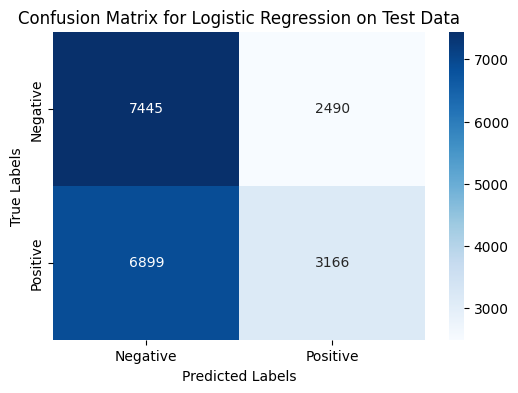

In [78]:
# confusion matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Logistic Regression on Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Model 2: XGBoost

In [79]:
# logging setup for resource monitoring
log = {"memory": [], "cpu": [], "gpu": [], "running": True}

# Initialize XGBoost model
xg_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# monitoring start time and system resources
start_time = time.time()

# starting the resource monitor in a separate thread
monitor_thread = Thread(target=monitor_resources_continuously, args=(log,))
monitor_thread.start()

# Training the model
xg_model.fit(train_tfidf, y_train)

# allowing monitoring thread to finish logging
time.sleep(1)

# stopping the resource monitoring
log["running"] = False
monitor_thread.join()

# monitoring end time and system resources
end_time = time.time()

# calculating training time
training_time = end_time - start_time

In [80]:
if len(log["memory"]) > 0:
    avg_memory = sum(log["memory"]) / len(log["memory"])
    peak_memory = max(log["memory"])
else:
    avg_memory = peak_memory = 0

if len(log["cpu"]) > 0:
    avg_cpu = sum(log["cpu"]) / len(log["cpu"])
    peak_cpu = max(log["cpu"])
else:
    avg_cpu = peak_cpu = 0

if len(log["gpu"]) > 0:
    avg_gpu = sum(log["gpu"]) / len(log["gpu"])
    peak_gpu = max(log["gpu"])
else:
    avg_gpu = peak_gpu = 0

# Print resource usage statistics
print(f"Training Time: {training_time:.2f} seconds")
print(f"Average Memory Usage: {avg_memory:.2f} MB")
print(f"Peak Memory Usage: {peak_memory:.2f} MB")
print(f"Average CPU Usage: {avg_cpu:.2f}%")
print(f"Peak CPU Usage: {peak_cpu:.2f}%")
print(f"Average GPU Usage: {avg_gpu:.2f}%")
print(f"Peak GPU Usage: {peak_gpu:.2f}%")

Training Time: 12.08 seconds
Average Memory Usage: 3157.99 MB
Peak Memory Usage: 3165.52 MB
Average CPU Usage: 58.65%
Peak CPU Usage: 100.00%
Average GPU Usage: 0.00%
Peak GPU Usage: 0.00%


### Model Prediction

In [84]:
y_train_pred = xg_model.predict(train_tfidf)
y_val_pred = xg_model.predict(val_tfidf)

In [85]:
# calculating accuracy scores

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_eval, y_val_pred)

In [86]:
# printing initial training results

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Training Accuracy: 82.05%
Validation Accuracy: 60.07%


### Model Prediction

In [87]:
y_test_pred = xg_model.predict(test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label=1)
recall = recall_score(y_test, y_test_pred, pos_label=1)
f1 = f1_score(y_test, y_test_pred, pos_label=1)

print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Testing Accuracy: 53.27%
Precision: 53.19%
Recall: 59.60%
F1 Score: 56.21%


In [88]:
# Printing initial results

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Training Accuracy: 82.05%
Testing Accuracy: 53.27%
Precision: 53.19%
Recall: 59.60%
F1 Score: 56.21%


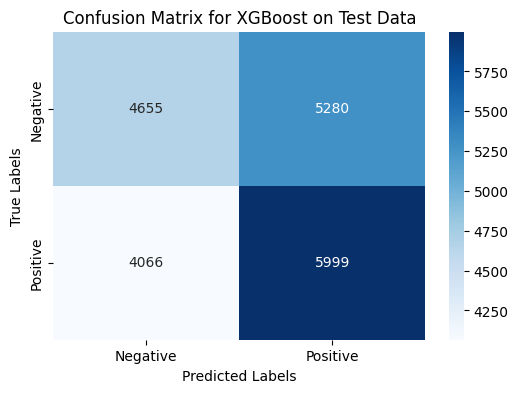

In [89]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for XGBoost on Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()